Udacity <a href="https://learn.udacity.com/nanodegrees/nd025/parts/cd1971/lessons/e3f2b25a-5e8a-404f-a1f8-18c3524ce867/concepts/e3f2b25a-5e8a-404f-a1f8-18c3524ce867-project-rubric">Rubric</a>


In [48]:
# imports
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import ticker
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import (
    SelectFromModel,
    SelectKBest,
    f_regression,
    mutual_info_regression,
    r_regression,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, SGDRegressor
from sklearn.metrics import (
    make_scorer,
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline, make_union
from sklearn.preprocessing import OrdinalEncoder  # for dealing with ordinal categories
from sklearn.preprocessing import (
    TargetEncoder,  # for dealing with high cardinal categories, for now use one-hot encoder
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVR

%matplotlib inline


warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# read data
df = pd.read_csv("train.csv")

# Business Understanding

## Project Overview

This project will explore the Kaggle housing dataset.  

## Problem Statement

Explore how various feature selection and regularization (L1 & L2) methods influence predicted housing prices when applying regression models.

Questions to be answered in this project:
* What is the prediction score of a baseline regression model using no feature selection or regularization using:
    * all features? i.e. the case of no feature selection.
    * only all PCA components of numerical features? to gauge how PCA components alone shape the prediction. 
    * all features + all PCA components? to see how all of our base features + newly created PCA components perform with zero feature selection.  
<br>
<br>
* First establish a baseline regression model without any feature selection, and then test various feature selection capabilities with that model for comparison.
* Models to be evaluated.
    * Simple Linear Regression
    * Ridge
    * SGDRegressor
    * Lasso
    * ElasticNet
<br>
<br>
* For each model above:
    * first test the baseline case with 1) all original features, 2) all PCA features of numerical features and 3) all original features + all PCA features.
    * Apply various feature selection/regularization algorithms and compare prediction scores with baseline data.
<br>
<br>
* Which model performed the best overall across all tested models?
<br>
<br>
* What insights can be made regarding how feature selection has impacted our prediction scores?
<br>
<br>
My hypothesis is that the best performing model overall (as measured using the cross-validation scores) will be 1) a model that is not the Simple Linear Regression model and 2) apply a feature selection or a L1/L2 regularization algorithm that picks a mix of PCA components + original features.  I think this best performing model on the cross-validation set will perform relatively worse on the training data.  I believe the baseline simple linear regression model using all original features + all PCA components with no feature selection to perform the worst as this should overfit the training data.  The training score on this data may be one of the highest overall but the cross-validation score I believe will be one of the lowest if not the lowest overall score.

## Metric

The metric that will be used to evaluate all models is the Root Mean Squared Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price.  As Kaggle notes taking the logs means that the errors in predicting expensive houses and cheap houses will affect the results equally.

Further comparisons will be made between the RMSE of the training data vs the testing data for the different complexities of the models.

# Data Understanding

View the top few rows of the data

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Explore the numeric variables

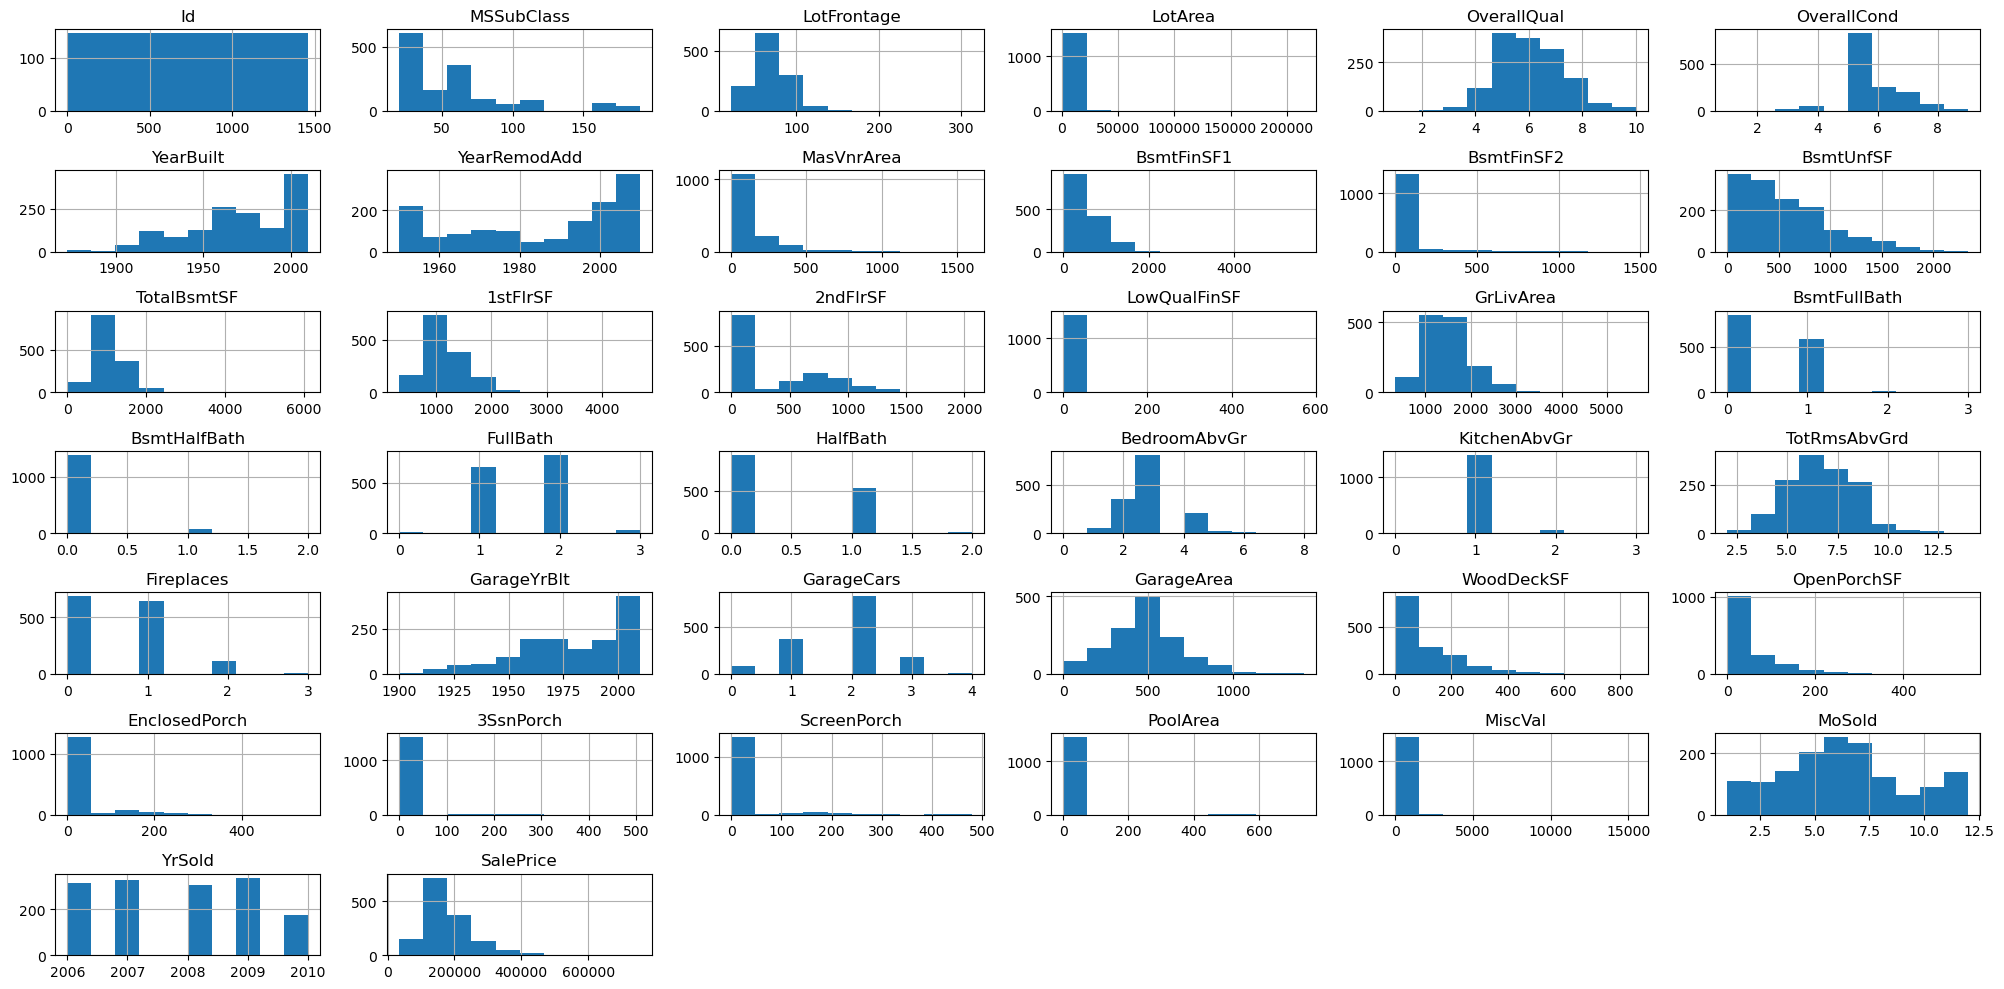

In [4]:
df.hist(figsize=(20, 10))
plt.tight_layout()

General Observations:
* Sales data is roughly between 2006 and 2010.
* More houses were sold in the summer months.
* Most houses are between 1000 - 2000 square feet.
* Most houses were built after 1950.

Take a look at the correlation of the numeric values vs. the sale price

In [5]:
corr = df.corr(numeric_only=True)
corr.style.background_gradient(cmap="coolwarm", axis=None)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451

General Observations:
* Sales Price looks to be correlated with:
    * OverallQual: Rates the overall material and finish of the house. Correlation is ~80% which seems significant.
    * GrLivArea: Above grade (ground) living area square feet.
    * Other features related to square feet like GarageCars, GarageArea, Total basement sq ft, etc...
 
The above correlations make a lot of sense.  It should be useful to create some latent features with PCA.  This will be explored more later.

Check for outlier sale price

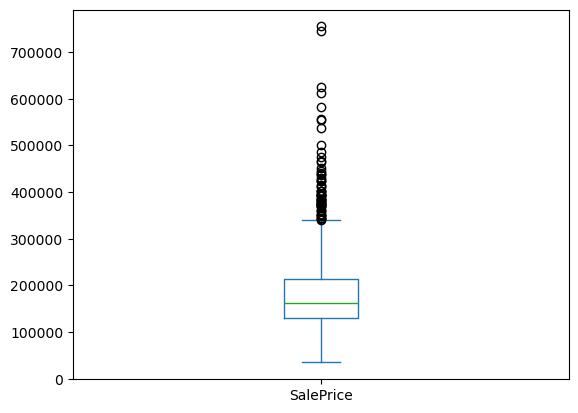

In [6]:
df.plot(y="SalePrice", kind="box");

There are two homes above 700K but that doesn't seem out of the norm for the housing market, so those will be left in.  This data distribution appears skewed.  It makes sense that the data would be lognormally distributed since negative home prices don't make sense.  Let's look at the original distribution and the log-transformed distribution.

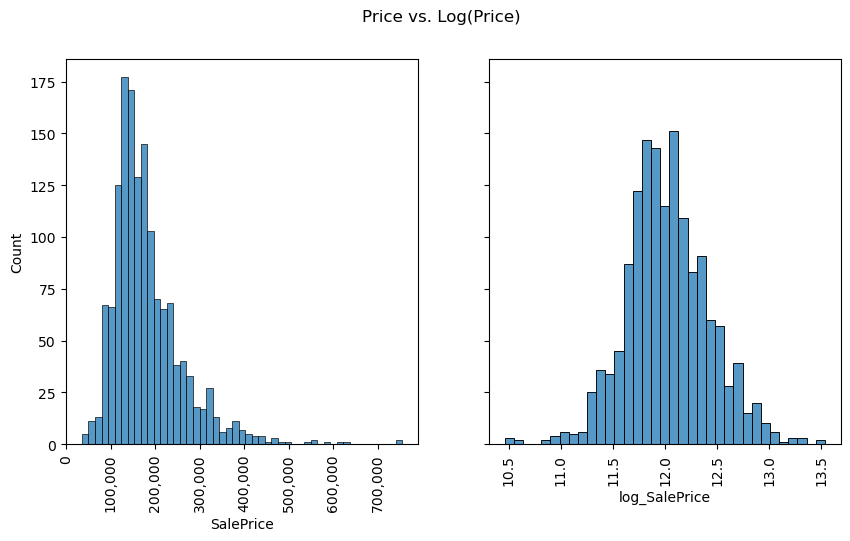

In [7]:
# first let's add the log sale price
df["log_SalePrice"] = df["SalePrice"].apply("log")

# graph both
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.histplot(df, x="SalePrice", ax=axs[0])
sns.histplot(df, x="log_SalePrice", ax=axs[1])
fig.suptitle("Price vs. Log(Price)")
axs[0].tick_params(axis="x", labelrotation=90)
axs[1].tick_params(axis="x", labelrotation=90)
formatter = ticker.StrMethodFormatter("{x:,.0f}")
axs[0].xaxis.set_major_formatter(formatter)

Due to the skewed SalePrice distribution the log of the sale price will be the feature used for predicting,

## Explore the categorical features

In [8]:
non_numeric_cols = df.select_dtypes(exclude="number").columns

In [9]:
# print some top info for each of the non-numeric columns
df_len = df.shape[0]
for col in df[non_numeric_cols]:
    names = list(df[col].value_counts().index)
    sliced_names = [str(name)[:25] for name in names]
    values = list(df[col].value_counts())
    print(f"{df[col].name}: {list(zip(sliced_names, values))}")

MSZoning: [('RL', 1151), ('RM', 218), ('FV', 65), ('RH', 16), ('C (all)', 10)]
Street: [('Pave', 1454), ('Grvl', 6)]
Alley: [('Grvl', 50), ('Pave', 41)]
LotShape: [('Reg', 925), ('IR1', 484), ('IR2', 41), ('IR3', 10)]
LandContour: [('Lvl', 1311), ('Bnk', 63), ('HLS', 50), ('Low', 36)]
Utilities: [('AllPub', 1459), ('NoSeWa', 1)]
LotConfig: [('Inside', 1052), ('Corner', 263), ('CulDSac', 94), ('FR2', 47), ('FR3', 4)]
LandSlope: [('Gtl', 1382), ('Mod', 65), ('Sev', 13)]
Neighborhood: [('NAmes', 225), ('CollgCr', 150), ('OldTown', 113), ('Edwards', 100), ('Somerst', 86), ('Gilbert', 79), ('NridgHt', 77), ('Sawyer', 74), ('NWAmes', 73), ('SawyerW', 59), ('BrkSide', 58), ('Crawfor', 51), ('Mitchel', 49), ('NoRidge', 41), ('Timber', 38), ('IDOTRR', 37), ('ClearCr', 28), ('StoneBr', 25), ('SWISU', 25), ('MeadowV', 17), ('Blmngtn', 17), ('BrDale', 16), ('Veenker', 11), ('NPkVill', 9), ('Blueste', 2)]
Condition1: [('Norm', 1260), ('Feedr', 81), ('Artery', 48), ('RRAn', 26), ('PosN', 19), ('RRAe

General Observations:
* It looks like some columns have high cardinality (Neighborhood, Exterior1st, Exterior2nd).
* Some features don't appear too informative (Street, Utilities) as almost 100% of the values are only in one category.
* It looks like for many of the features the categories are very skewed to the top value (where the second highest value in a column is almost a factor of 10 lower than the top value).
* Some non-numeric features appear ordinal (like BsmtQal and BsmtCond).  These could be re-encoded to numerical.

How many categories have more than 3 values (not including n/a).

In [10]:
greater = 0
total = 0
for col in df[non_numeric_cols]:
    num = df[col].value_counts().shape[0]
    if num > 3:
        greater += 1
    total += 1

print(
    f"{greater} non-numeric columns out of {total} have more than 3 categories.  This is a ratio of {greater/total:.2%}."
)

34 non-numeric columns out of 43 have more than 3 categories.  This is a ratio of 79.07%.


Due to the high number of columns with more than 3 categories, target encoding will be used for simplicity.  Target encoding uses the target mean conditioned on the categorical feature for encoding un-ordered categories.  This is useful for features with high cardinality.  See scikit-learn discussion <a href="https://scikit-learn.org/stable/modules/preprocessing.html#target-encoder">here.</a>



# Data Preparation

## Identify columns with missing data

In [11]:
# ensure all missing data coded the same
df.fillna(np.nan, inplace=True)

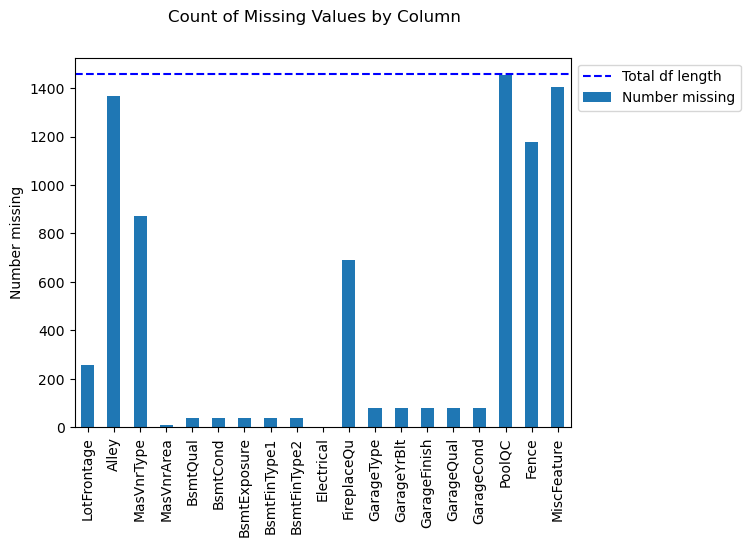

In [12]:
# identify and plot
missing_cols = df.columns[df.isna().any()].to_list()

fig, ax = plt.subplots()
df[missing_cols].isna().sum().plot.bar(ax=ax, label="Number missing")
ax.set_ylabel("Number missing")
fig.suptitle("Count of Missing Values by Column")
plt.axhline(y=df.shape[0], color="b", linestyle="--", label="Total df length")
ax.legend(bbox_to_anchor=(1, 1));

Based on the above it looks like dropping columns with more than 600 missing values might be a good thing to do.

However, when reading the data description, we see the following for PoolQC: NA = No Pool

So, in this case a value of NA is actually informative in that it means there is no pool.  This is different from a typical na value as typically na would mean we don't know anything about the pool value.  But in this case we know NA means there is no pool.  This information should be retained.

After reading through more descriptions we learn the same can be said of the following categories with > 600 missing values:
Alley, FireplaceQu, PoolQC, Fence, MiscFeature.

MasVnrType is a bit confusing as it uses the term None instead of NA.  Due to this confusion I am going to assume NA is truly missing to be safe.

Therefore the only column really worth dropping with >600 missing values is the MasVnrType field.

In [13]:
df.drop(columns=["MasVnrType"], inplace=True)

Now let's discuss the columns with smaller number of missing values.  Specifically the columns related to the Basement and Garage.  
The data descriptions for categorical + ordinal columns GarageType, GarageFinish, GarageQual, GarageCond, BasmtQual, BsmtCond, BsmtExposure all say that the NA values mean there is no Garage or Basement.  Therefore these values will be treated as their own category during Target Encoding.

Per Sklearn, "TargetEncoder considers missing values, such as np.nan or None, as another category and encodes them like any other category. Categories that are not seen during fit are encoded with the target mean, i.e. target_mean_." <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html">Target Encoding<a/>

Numerical columns BsmtFinType1, BsmtFinType with NA values will be also be assumed to be houses with no basement for simplicity. These will be imputed with 0 as in 0 sq ft. MasVnrArea will be treated the same for simplicity.

Due to the low number of na values in Electrical (1 row), this will be left to be handled by the Target Encoder.

## Identify rows with missing values

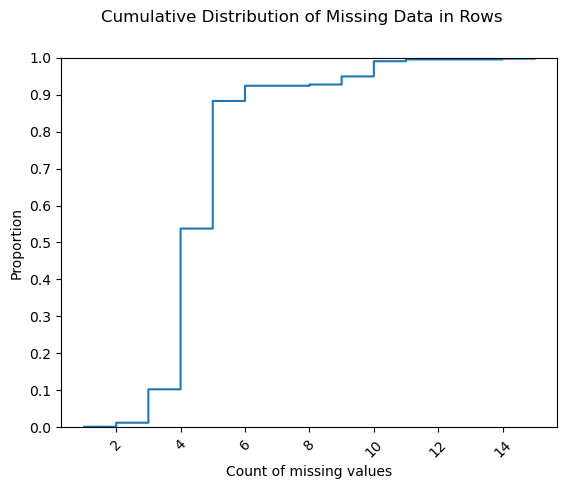

In [14]:
# identify and plot missing rows
missing_row = df.shape[1] - df.count(axis=1)  # number of missing values per row

fig, ax = plt.subplots()
sns.ecdfplot(missing_row, ax=ax)
plt.xticks(rotation=45)
ax.set_yticks(list(np.arange(0.0, 1.1, 0.1)))
plt.suptitle("Cumulative Distribution of Missing Data in Rows")
ax.set_xlabel("Count of missing values");

There are not many rows with lots of missing values.  Therefore these will be left as is and their values will be imputed as described above.  The chart above shows that ~90% of rows are missing 5 or fewer values. 

# Data Modeling

## Create X and y matrices

In [15]:
y = df["SalePrice"].copy()
X = df.drop(
    columns=["SalePrice", "log_SalePrice", "Id"]
).copy()  # drop the log sale price and handle that transformation via the model pipeline, we also don't need Id

## Define the numeric, categorical, and ordianal features

In [16]:
numeric_features = [
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",  # most likely na is no basement
    "BsmtFinSF2",  # most likely na is no basement
    "BsmtUnfSF",  # same
    "TotalBsmtSF",  # same
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",  # na is prob no garage
    "GarageCars",  # na is prob no garage
    "GarageArea",  # na is prob no garage
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "MoSold",
    "YrSold",
]

categorical_features = [
    "MSSubClass",  # was numeric but by description should be categorical
    "Alley",
    "MSZoning",
    "Street",
    "LotShape",
    "LandContour",
    "Utilities",
    "LotConfig",
    "LandSlope",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "ExterQual",
    "ExterCond",
    "Foundation",
    "Heating",
    "CentralAir",
    "Electrical",
    "Functional",
    "GarageType",
    "GarageFinish",
    "PavedDrive",
    "Fence",
    "SaleType",
    "MiscFeature",
    "SaleCondition",
]

# ordinal features will be encoded, so initially need to define the categories for each feature
ordinal_features_dict = {
    "FireplaceQu": ["Po", "Fa", "TA", "Gd", "Ex", np.nan],
    "PoolQC": ["Fa", "TA", "Gd", "Ex", np.nan],
    "BsmtQual": ["Po", "Fa", "TA", "Gd", "Ex", np.nan],
    "BsmtCond": ["Po", "Fa", "TA", "Gd", "Ex", np.nan],
    "BsmtExposure": ["No", "Mn", "Av", "Gd", np.nan],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ", np.nan],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ", np.nan],
    "HeatingQC": ["Po", "Fa", "TA", "Gd", "Ex"],
    "KitchenQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "GarageQual": ["Po", "Fa", "TA", "Gd", "Ex", np.nan],
    "GarageCond": ["Po", "Fa", "TA", "Gd", "Ex", np.nan],
}

ordinal_features = list(ordinal_features_dict.keys())

## Build a prepocessing pipeline

### some setup

make a scorer that can be used to evaluate the models.

In [17]:
# custom scorer
def RMSE_log(y_true, y_pred):
    score = root_mean_squared_error(np.log(y_true), np.log(y_pred))
    return score


myscore = make_scorer(RMSE_log)

split the data

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=38
)

Make a function that can take 3 pipelines (original categories, pca only, orginal + pca) and a classifier and return the results for the no feature selection case.



In [19]:
def no_feature_selection_baseline(X, y, pipeline_list, classifier, scorer):
    """
    Test the baseline case without any feature selection vs an sklearn classifier.  This function will take the 3 baseline cases (all features, nummeric PCA, and all features + numeric PCA)
    and return their CV and training score for each.

    Parameters:
        - X: the X matrix to be evaluated.
        - y: the y matrix to be evaluated.
        - pipeline list: A list of sklearn pipelines in the order of all 1) features  2) numeric PCA and 3) all features + numeric PCA
        - classifier: the Sklearn classifier object to be used to create the prediction.
        - scorer: the custom scorer used to create the CV and training scores.

    Returns:
        - training_score_list: The RMSE of the log prediction using the training data. will be a list of 3 values matching the baseline case list above.
        - CV_score_list: the RMSE of the log prediction using cross-validation.    will be a list of 3 values matching the baseline case list above.
        - train_score_stdev_list: standard deviation of the training scores.
        - C_score_stdev_list: standard deviation of the cross-validation scores.
    """

    # create the transform for the y value
    classifier_transform = TransformedTargetRegressor(
        regressor=classifier, func=np.log, inverse_func=np.exp
    )

    training_score_list, CV_score_list, train_score_stdev_list, CV_score_stdev_list = (
        [],
        [],
        [],
        [],
    )
    for i, pipeline in enumerate(pipeline_list):
        clf = make_pipeline(pipeline, classifier_transform)

        # score the model
        cv_results = cross_validate(
            clf,
            X,
            y,
            cv=5,
            scoring=scorer,
            return_train_score=True,
            verbose=3,
        )

        CV_score_list.append(np.mean(cv_results["test_score"]))
        CV_score_stdev_list.append(np.std(cv_results["test_score"]))
        training_score_list.append(np.mean(cv_results["train_score"]))
        train_score_stdev_list.append(np.std(cv_results["train_score"]))

        # print(clf.fit(X, y)[:-1].get_feature_names_out()) #- can delete when done

        print(f"-----Pipeline {i+1} complete------")

    return (
        training_score_list,
        CV_score_list,
        train_score_stdev_list,
        CV_score_stdev_list,
    )

In [20]:
def run_model(X, y, pipeline_list, classifier, scorer, verbose=0, name=None):
    """
    Test the baseline case without any feature selection vs an sklearn classifier.  This function will take the 3 baseline cases (all features, nummeric PCA, and all features + numeric PCA)
    and return their CV and training score for each.

    Parameters:
        - X: the X matrix to be evaluated.
        - y: the y matrix to be evaluated.
        - pipeline list: A list of sklearn pipelines in the order of all 1) features  2) numeric PCA and 3) all features + numeric PCA
        - classifier: the Sklearn classifier object to be used to create the prediction.
        - scorer: the custom scorer used to create the CV and training scores.
        - name: this is the name (str) of the type of run. to be used for chart labels later.

    Returns:
        - training_score_list: The RMSE of the log prediction using the training data. will be a list of 3 values matching the baseline case list above.
        - CV_score_list: the RMSE of the log prediction using cross-validation.    will be a list of 3 values matching the baseline case list above.
        - train_score_stdev_list: standard deviation of the training scores.
        - C_score_stdev_list: standard deviation of the cross-validation scores.
    """

    # create the transform for the y value
    classifier_transform = TransformedTargetRegressor(
        regressor=classifier, func=np.log, inverse_func=np.exp
    )

    (
        training_score_list,
        CV_score_list,
        train_score_stdev_list,
        CV_score_stdev_list,
        estimators_list,
    ) = (
        [],
        [],
        [],
        [],
        [],
    )
    print(f"Evaluating Model: {name}")
    for i, pipeline in enumerate(pipeline_list):
        clf = make_pipeline(pipeline, classifier_transform)

        # score the model
        cv_results = cross_validate(
            clf,
            X,
            y,
            cv=5,
            scoring=scorer,
            return_train_score=True,
            verbose=verbose,
            return_estimator=True,
        )

        CV_score_list.append(np.mean(cv_results["test_score"]))
        CV_score_stdev_list.append(np.std(cv_results["test_score"]))
        training_score_list.append(np.mean(cv_results["train_score"]))
        train_score_stdev_list.append(np.std(cv_results["train_score"]))
        estimators_list.append(cv_results["estimator"])

        # print(clf.fit(X, y)[:-1].get_feature_names_out()) #- can delete when done

        print(f"-----Pipeline {i+1} complete------")

    return (
        training_score_list,
        CV_score_list,
        train_score_stdev_list,
        CV_score_stdev_list,
        estimators_list,
        name,
    )

In [21]:
def store_output(
    results_df, model_name, pipe_names, train_scores, CV_scores, train_std, CV_std
):
    """
    Take the results from a test iteration and append them to the results dataframe

    Parameters:
        - results_df:

    Returns:
        - The appended dataframe

    """

    # write outputs to dataframe
    index_names = [[model_name], pipe_names]
    index = pd.MultiIndex.from_product(index_names, names=["TestType", "FeaturesUsed"])

    data = {
        "train_scores": train_scores,
        "CV_scores": CV_scores,
        "train_std": train_std,
        "CV_std": CV_std,
    }

    result = pd.DataFrame(data=data, index=index)
    results = pd.concat([results_df, result])
    return results

### Create the pipelines for the above function

Case for only the original features

In [22]:
# for the ordinal features we will need a list of the categories so the order of the values can be defined.
categories = list(ordinal_features_dict.values())

# pipeline to for transforming original features only
features_only = make_pipeline(
    make_column_transformer(
        (
            SimpleImputer(strategy="constant", fill_value=0),
            numeric_features,
        ),  # fill 0 as described in above missing data section
        (
            TargetEncoder(categories="auto", target_type="continuous", random_state=41),
            categorical_features,
        ),
        (
            OrdinalEncoder(
                categories=categories, encoded_missing_value=-1
            ),  # encode na values as -1 as na values mean the absence of the basement, garage, etc...
            ordinal_features,
        ),
    ),
    StandardScaler(),
)

Case for only PCA transformed numerical/ordinal columns

In [23]:
numerical_features_PCA = make_pipeline(
    make_column_transformer(
        (SimpleImputer(strategy="constant", fill_value=0), numeric_features),
        (
            OrdinalEncoder(categories=categories, encoded_missing_value=-1),
            ordinal_features,
        ),
        remainder="drop",  # drop the categorical features
    ),
    StandardScaler(),
    PCA(
        random_state=41,
    ),
)

Case for all original features + all numeric/ordinal PCA transformed features

In [24]:
combined_features = make_union(features_only, numerical_features_PCA)

Fit models and return results

In [25]:
# Create a list of the pipelines and their names so that these can be passed to a function to fit various regression models
pipes = [features_only, numerical_features_PCA, combined_features]
pipe_names = ["features_only", "numeric_PCA", "combined"]

In [26]:
# write a function to iterate over models and store their results
def iterate_over_models(classifier_tests, names, pipes, pipe_names):
    """
    This function will take in a list of regressors, iterate over and fit each model, and store the CV score and train score for each in a result data frame.

    Parameters:
        classifier_tests: A list of regressor objects to fit
        names: A list of strings describing the regression models
        pipes: A list of sklearn pipelines
        pipe_names: the list of strings that describe the number of features in the model (all original features, numeric PCA features only, all original + numeric PCA features)

    Returns:
        results: A results dataframe containing the training and CV scores.
    """
    results = pd.DataFrame()

    for classifier, name in zip(classifier_tests, names):
        train_scores, CV_scores, train_std, CV_std, estimators, name = run_model(
            X_train, y_train, pipes, classifier, myscore, name=name
        )

        # write outputs to dataframe
        results = store_output(
            results, name, pipe_names, train_scores, CV_scores, train_std, CV_std
        )

    return results

In [27]:
# write a function to plot the results
def plot_results(results, names, pipe_names):
    """
    This function will take the results dataframe and plot the training scores and CV scores of the fitted models as a bar chart.

    Parameters:
        results: the results dataframe containing the train scores and CV scores
        names: the list of strings that describe what classifiers have been fitted.
        pipe_names: the list of strings that describe the number of features in the model (all original features, numeric PCA features only, all original + numeric PCA features)

    Returns:
        Nothing, but a plot is displayed.
    """

    # data dictionaries used for plotting
    cv_scores_dict = {name: results["CV_scores"].loc[name].values for name in names}
    cv_std_dict = {name: results["CV_std"].loc[name].values for name in names}

    train_scores_dict = {
        name: results["train_scores"].loc[name].values for name in names
    }
    train_std_dict = {name: results["train_std"].loc[name].values for name in names}

    x = np.arange(len(pipe_names))  # label locations
    width = 0.1  # width of the bars
    multiplier = 0

    fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

    for test in names:
        offset = width * multiplier
        rects_cv = axs[1].bar(
            x + offset, cv_scores_dict[test], width, label=test, yerr=cv_std_dict[test]
        )
        rects_train = axs[0].bar(
            x + offset,
            train_scores_dict[test],
            width,
            label=test,
            yerr=train_std_dict[test],
        )
        labels_cv = axs[1].bar_label(rects_cv, padding=3, fmt="{:.3}")
        labels_train = axs[0].bar_label(rects_train, padding=3, fmt="{:.3}")
        [label.set_rotation(90) for label in labels_cv]
        [label.set_rotation(90) for label in labels_train]
        multiplier += 1

    axs[1].set_ylabel("RMSE")
    axs[0].set_ylabel("RMSE")
    axs[1].set_title("CV Scores")
    axs[0].set_title("Train Scores")
    axs[0].set_xticks(x + width, pipe_names)
    axs[1].set_xticks(x + width, pipe_names)
    axs[0].legend(loc="upper right")

Run models and store outputs

In [60]:
# iterate over models
# this will be simple linear regression along with some selectkbest
classifier_tests = [
    LinearRegression(),
    make_pipeline(SelectKBest(f_regression, k=3), LinearRegression()),
    make_pipeline(SelectKBest(f_regression, k=10), LinearRegression()),
    make_pipeline(SelectKBest(f_regression, k=20), LinearRegression()),
    make_pipeline(SelectFromModel(RandomForestRegressor()), LinearRegression()),
]
names = [
    "Baseline Regression",
    "LR - 3 Best",
    "LR - 5 Best",
    "LR - 10 Best",
    "LR - Select From RF"
]

results = iterate_over_models(classifier_tests, names, pipes, pipe_names)

Evaluating Model: Baseline Regression
-----Pipeline 1 complete------
-----Pipeline 2 complete------
-----Pipeline 3 complete------
Evaluating Model: LR - 3 Best
-----Pipeline 1 complete------
-----Pipeline 2 complete------
-----Pipeline 3 complete------
Evaluating Model: LR - 5 Best
-----Pipeline 1 complete------
-----Pipeline 2 complete------
-----Pipeline 3 complete------
Evaluating Model: LR - 10 Best
-----Pipeline 1 complete------
-----Pipeline 2 complete------
-----Pipeline 3 complete------
Evaluating Model: LR - Select From RF
-----Pipeline 1 complete------
-----Pipeline 2 complete------
-----Pipeline 3 complete------


Plot the results

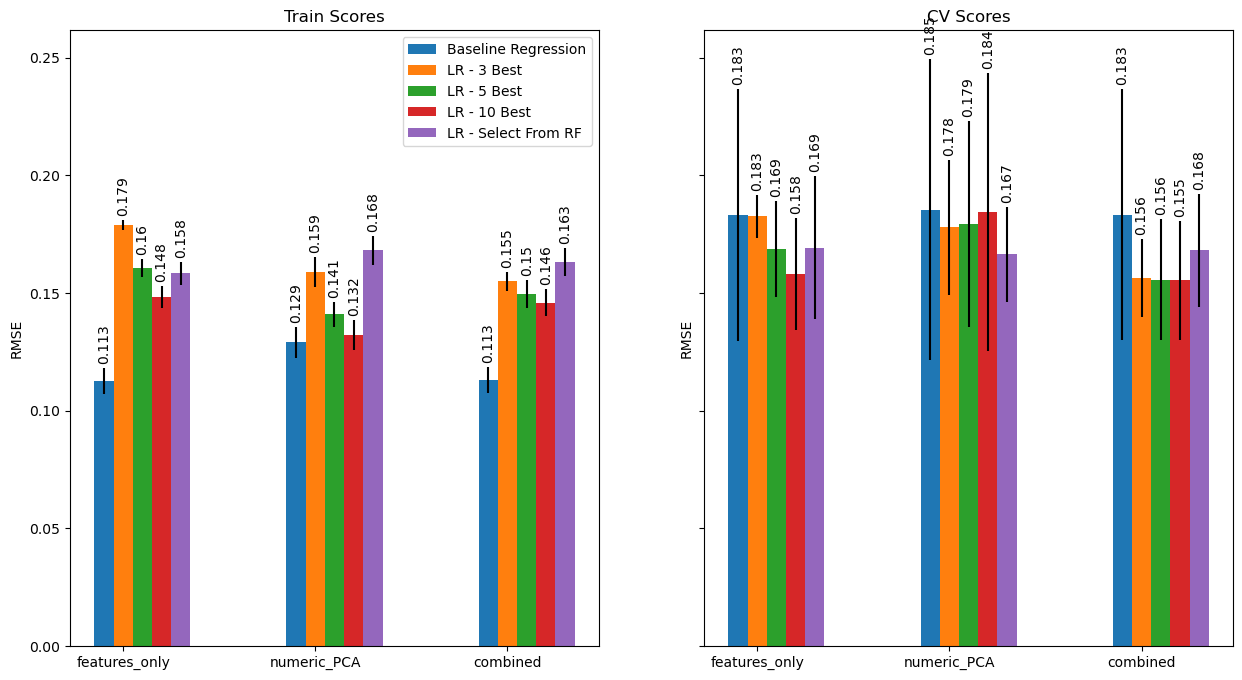

In [61]:
plot_results(results, names, pipe_names)

In [68]:
# iterate over models
# try gradient descent
classifier_tests = [
    SGDRegressor(penalty=None, random_state=41),
    SGDRegressor(penalty='l1', alpha=0.0001, random_state=41),
    SGDRegressor(penalty='l1', alpha=0.001, random_state=41),
    SGDRegressor(penalty='l1', alpha=0.01, random_state=41),
    SGDRegressor(penalty='l1', alpha=0.05, random_state=41),
]
names = [
    "Baseline SGDRegressor",
    "SGD alpha = 0.0001",
    "SGD alpha = 0.001",
    "SGD alpha = 0.01",
    "SGD alpha = 0.05",
]

results = iterate_over_models(classifier_tests, names, pipes, pipe_names)

Evaluating Model: Baseline SGDRegressor
-----Pipeline 1 complete------
-----Pipeline 2 complete------
-----Pipeline 3 complete------
Evaluating Model: SGD alpha = 0.0001
-----Pipeline 1 complete------
-----Pipeline 2 complete------
-----Pipeline 3 complete------
Evaluating Model: SGD alpha = 0.001
-----Pipeline 1 complete------
-----Pipeline 2 complete------
-----Pipeline 3 complete------
Evaluating Model: SGD alpha = 0.01
-----Pipeline 1 complete------
-----Pipeline 2 complete------
-----Pipeline 3 complete------
Evaluating Model: SGD alpha = 0.05
-----Pipeline 1 complete------
-----Pipeline 2 complete------
-----Pipeline 3 complete------


Plot the results

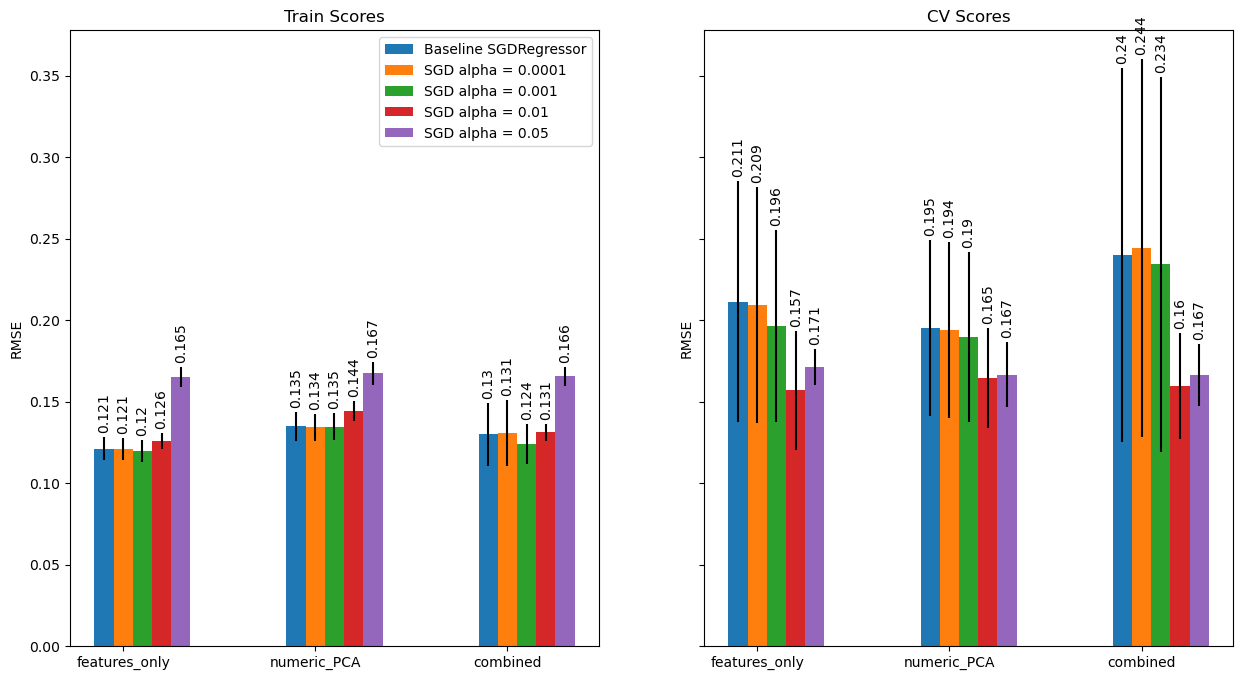

In [69]:
plot_results(results, names, pipe_names)

## Try Regression with Feature Selection

## check some of the coeffiencts used and the mean/std

In [ ]:
train_scores, CV_scores, train_std, CV_std, estimators, name = run_model(
    X_train,
    y_train,
    pipes,
    Lasso(alpha=0.01),
    myscore,
    verbose=3,
)

In [ ]:
# pipeline, model, classifier
estimators[2][0][-1].regressor_.coef_

In [ ]:
estimators[0][0][0]

In [ ]:
# pipeline, model, classifier
features_used = np.where(~np.isclose(estimators[2][0][-1].regressor_.coef_, 0))
estimators[2][0][0].get_feature_names_out()[features_used]

In [ ]:
# pipeline, model, classifier
features_used = np.where(~np.isclose(estimators[0][0][-1].regressor_.coef_, 0))
estimators[0][0][0].get_feature_names_out()[features_used]

In [ ]:
# selectKBest
train_scores, CV_scores, train_std, CV_std, estimators, name = run_model(
    X_train,
    y_train,
    pipes,
    make_pipeline(SelectKBest(f_regression, k=3), LinearRegression()),
    myscore,
    verbose=3,
    name="hi",
)

In [ ]:
features_used = estimators[0][0][-1].regressor_[-2].get_support(indices=True)

In [ ]:
estimators[0][0]["pipeline"]["columntransformer"].get_feature_names_out()[features_used]

# Result Evaluation

# Deployment